Benchmark the new `DoiRegressionModel` class

In [79]:
import os
from sys import path
from itertools import product

cwd = os.getcwd()
path.append(f"{cwd}/..")
import pandas as pd
from database import (ID, create_tables, drop_tables, get_next_chunk_from_db,
                      reset_progression, save_dois)
from doi_function import (compute_dois, reset_doi_component,
                          set_dimension_intervals, set_dimension_weights)
from doi_regression_model import *
from storage_strategy.windowing_storage import WindowingStorage

from server import taxi_process_chunk


def reset(weights: dict, intervals: dict): 
  drop_tables()

  create_tables(
      row_data_path="../data/nyc_taxis.shuffled_full.csv.gz",
      column_data_path="../data/nyc_taxis.shuffled_full.parquet",
      id_column="tripID",
      total_size=112145904,
      process_chunk_callback=taxi_process_chunk,
  )

  reset_progression()
  reset_doi_component()
  set_dimension_weights(weights)
  set_dimension_intervals(intervals)


CHUNK_SIZE = 1000
WEIGHTS = {
  "trip_distance": 0.25,
  "total_amount": 0.25,
  "tip_amount": 0.25,
  "trip_duration": 0.25,
}
INTERVALS = {
  "trip_distance": [16, 20],
  "total_amount": [34, 74],
  "tip_amount": [4, 12],
  "trip_duration": [3, 5],
}

reset(intervals=INTERVALS, weights=WEIGHTS)


def get_next_progressive_result(
    storage: StorageStrategy, 
    get_context = None, 
    chunk_size: int=CHUNK_SIZE,
  ):
  '''Wrapper function for getting a new chunk, computing the DOI function on it and storing the data
     for later retrieval in the storage.'''

  # get chunk and compute context
  chunk_df = get_next_chunk_from_db(chunk_size, as_df=True)
  
  context_df = pd.DataFrame([], columns = chunk_df.columns)
  if get_context is not None:
    context_df = get_context()

  # compute the DOI over chunk + context
  df = pd.concat([chunk_df, context_df], ignore_index=True)
  dois = compute_dois(df)  # HACK: compatibility with DoiComponent class
  new_dois = dois[:len(chunk_df)]

  storage.insert_chunk(chunk_df, 0)
  save_dois(ids=chunk_df[ID].tolist(), dois=new_dois.reshape((-1, )).tolist())

  return chunk_df, new_dois


@dataclass
class Benchmark():
  max_depth: int = 3
  n_chunks: int = 25
  chunk_size: int or range = 1000
  context_size: int or range = 0
  intervals: int or range = 0
  with_error_stats: bool = False

  def compute_doi_error_stats(self, storage: StorageStrategy):
    all_items_df = storage.get_available_items()

    ground_truth_dois = pd.DataFrame(all_items_df[ID])
    ground_truth_dois["doi"] = compute_dois(all_items_df)
    ground_truth_dois.set_index(ID, inplace=True)

    stored_dois = storage.get_available_dois(with_ids=True)
    stored_dois = pd.DataFrame(stored_dois, columns=[ID, "doi"])
    stored_dois.set_index(ID, inplace=True)
  
    df = ground_truth_dois.join(stored_dois, lsuffix="gt", rsuffix="stored")

    # if storage is empty, then doistored is empty, causing an error in the subtraction
    if pd.isnull(df["doistored"].iloc[0]):
      return pd.Series([0], dtype="float64").describe()
    else:
      return (df["doigt"] - df["doistored"].astype(np.float64)).describe()

  def get_conditions(self):
    max_depths = self.max_depth if type(self.max_depth) is range else [self.max_depth]
    test_n_chunks = self.n_chunks if type(self.n_chunks) is range else [self.n_chunks]
    chunk_sizes = self.chunk_size if type(self.chunk_size) is range else [self.chunk_size]
    context_sizes = self.context_size if type(self.context_size) is range else [self.context_size]
    intervals = self.intervals if type(self.intervals) is range else [self.intervals]

    return max_depths, test_n_chunks, chunk_sizes, context_sizes, intervals

  def run(self):
    scores = []
    
    max_depths, test_n_chunks, chunk_sizes, context_sizes, intervals = self.get_conditions()

    # creates full cartesian product product of the iterable test variables
    test_cases = product(max_depths, chunk_sizes, context_sizes, intervals, test_n_chunks)

    for max_depth, chunk_size, context_size, interval, n_chunks in test_cases:
      reset(intervals=INTERVALS, weights=WEIGHTS)
      storage = WindowingStorage(max_size=10000000)
      model = DoiRegressionModel(storage, max_depth=max_depth)

      for i in range(n_chunks):
        # no context on first iteration because storage is empty
        if i == 0:
          chunk_df, new_dois = get_next_progressive_result(storage, chunk_size=chunk_size)
          model.update(chunk_df, new_dois)
        # ... otherwise use context
        else:
          chunk_df, new_dois = get_next_progressive_result(
            storage,
            chunk_size=chunk_size,
            get_context=lambda: model.get_context_items(context_size)
          )

        score = pd.Series({
          "max_depth": max_depth,
          "chunk_size": chunk_size,
          "context_size": context_size,
          "interval": interval,
          "n_chunks": n_chunks,
          "chunk": i,
          "score": model.score(chunk_df, new_dois)
        })

        if self.with_error_stats:
          error_stats = self.compute_doi_error_stats(storage)
          score["error_mean"] = error_stats["mean"]
          score["error_std"] = error_stats["std"]
          score["error_min"] = error_stats["min"]
          score["error_max"] = error_stats["max"]

        if i == 0 or interval == 0 or i % interval == 0:
          model.update(chunk_df, new_dois)

        scores += [score]
    
    return pd.DataFrame(scores)



def benchmark_max_depth(tested_max_depths: range = range(1, 10)):
  '''Measures how varying `max_depth` parameter influences progressive DOI prediction scores, over 
  a series of chunks (without updates) --- how stable/overfitted is the tree model.'''
  benchmark = Benchmark(max_depth=tested_max_depths)
  scores = benchmark.run()
  return scores


def benchmark_retraining_intervals(tested_intervals: range = range(25)):
  '''Measures how varying the update interval influences progressive DOI prediction scores.'''
  benchmark = Benchmark(intervals=tested_intervals)
  scores = benchmark.run()
  return scores


def benchmark_chunk_size(tested_sizes: range = range(1000, 110000, 10000)):
  '''Measures how varying the chunk size influences the progressive DOI prediction scores (without
   updates, without context)'''
  benchmark = Benchmark(chunk_size=tested_sizes)
  scores = benchmark.run()
  return scores


def benchmark_context_size(tested_sizes: range = range(0, 11000, 1000)):
  '''Measures how varying the context size influences the progressive DOI prediction scores (without
   updates)'''
  benchmark = Benchmark(context_size=tested_sizes)
  scores = benchmark.run()
  return scores


def benchmark_doi_error():
  '''Measures the changes in DOI error throughout the progression, when no optimizations are 
   applied.'''
  benchmark = Benchmark(n_chunks=100, with_error_stats=True)
  scores = benchmark.run()

  return pd.DataFrame(scores)

def benchmark_doi_error_with_optimizations():
  '''Measures the changes in DOI error throughout the progression, with regression-based 
  optimizations applied.'''
  benchmark = Benchmark(n_chunks=100, context_size=1000, interval=5, with_error_stats=True)
  scores = benchmark.run()

  return pd.DataFrame(scores)

# TODO: show reduction in error when using the regression tree as context model

# results: max_depth = 3 has best peformance, then no improvement/worse for bigger values
# max_depth_results = benchmark_max_depth()

# results: trivial best results for 0 and 1, score std for 3-8 above 0.9 
# intervals_results = benchmark_retraining_intervals()

# results: the larger the context the worse the scores.
# context_size_results = benchmark_context_size()

# results: the larger the chunk size, the better the scores
# chunk_size_results = benchmark_chunk_size()

# results: error increases (mean, std, max) with every chunk logarithmically
# doi_error_results = benchmark_doi_error()

# results:
optimized_doi_error_results = benchmark_doi_error_with_optimizations()

<AxesSubplot:>

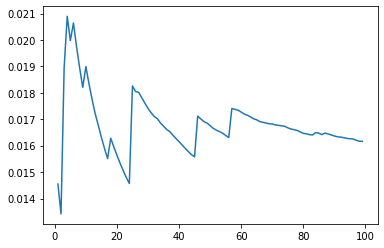

In [80]:
optimized_doi_error_results["error_std"].plot()

<AxesSubplot:>

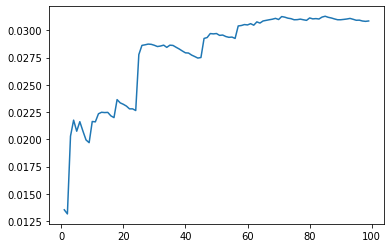

In [76]:
# doi_error_results["mean"].plot()
doi_error_results["error_std"].plot()

<AxesSubplot:title={'center':'score'}, xlabel='max_depth'>

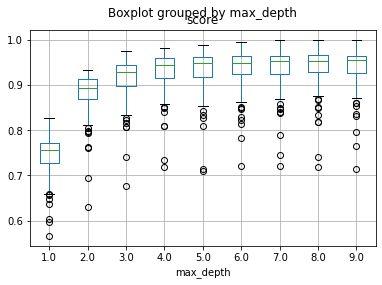

In [10]:
max_depth_results.boxplot(column="score", by="max_depth")

<AxesSubplot:title={'center':'score'}, xlabel='interval'>

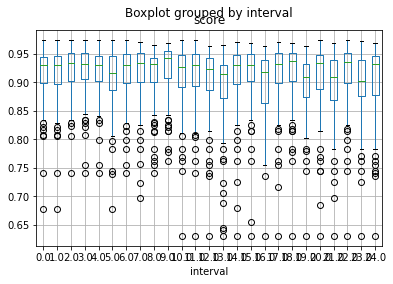

In [11]:
intervals_results.boxplot(column="score", by="interval")

<AxesSubplot:title={'center':'score'}, xlabel='context_size'>

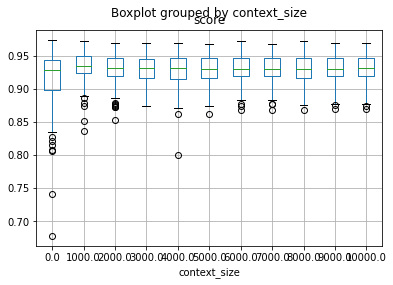

In [12]:
context_size_results.boxplot(column="score", by="context_size")

<AxesSubplot:title={'center':'score'}, xlabel='chunk_size'>

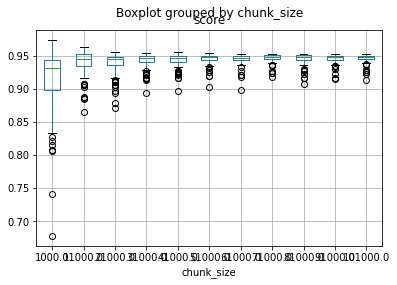

In [13]:
chunk_size_results.boxplot(column="score", by="chunk_size")